# Supervised Learning Algorithm - Lab 4 - IS1
### This notebook implements a CNN to train on the MNIST dataset to predict handwritten digits. 

In [1]:
# First, the necessary libraries are imported
import tensorflow as tf
import random
# data manipulation libraries
import numpy as np
import pandas as pd	

# visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

2025-05-26 11:56:02.981527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-26 11:56:02.997164: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-26 11:56:03.002965: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-26 11:56:03.080334: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data prepreparation and visualisation

In [2]:
# MNIST is an inbuilt dataset on tensorflow
mnist = tf.keras.datasets.mnist

# split the data into test and train sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# check the size of the datsets
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [3]:
# We have 60000 datapoints in train dataset and 10000 datapoints in test dataset
# each denoting pixel information of a 28 * 28 image of a handwritten number

# Normalizing the data by divinding it with 255
# The reason is because the pixel values of the image can vary between 0-255
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
# combine the x , y train and test arrays into pandas dataframe for EDA purpose

# unwrapping the dataset such that each row contains the pixel information of 
# each image and storing in the dataframe

# using the reshape function to convert a 3d array to 2d
# The number of rows remain same , the 28 * 28 matrix containing pixel info is
# unwrapped into a single row
mnist_train = pd.DataFrame(x_train.reshape(x_train.shape[0], 
                                           x_train.shape[1] * x_train.shape[2]))

# repeat the same for test data
mnist_test = pd.DataFrame(x_test.reshape(x_test.shape[0], 
                                           x_test.shape[1] * x_test.shape[2]))

# Create column names for dataframe to make it more readable
colnames = ['Pixel'+str(i) for i in range(1,785)]

mnist_train.columns = colnames
mnist_test.columns = colnames

# concatenate the labels into the test and train dataframe
mnist_train['label'] = y_train
mnist_test['label'] = y_test


mnist_train.head()

,Pixel1,Pixel2,Pixel3,Pixel4,Pixel5,Pixel6,Pixel7,Pixel8,Pixel9,Pixel10,...,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel782,Pixel783,Pixel784,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


In [5]:
# check if there is any NaN or missing datapoints
mnist_train.isnull().values.sum()

0

/tmp/ipykernel_12181/482897404.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=mnist_train, palette="Set3").set(


[Text(0.5, 1.0, 'Label distribution in Training Data')]

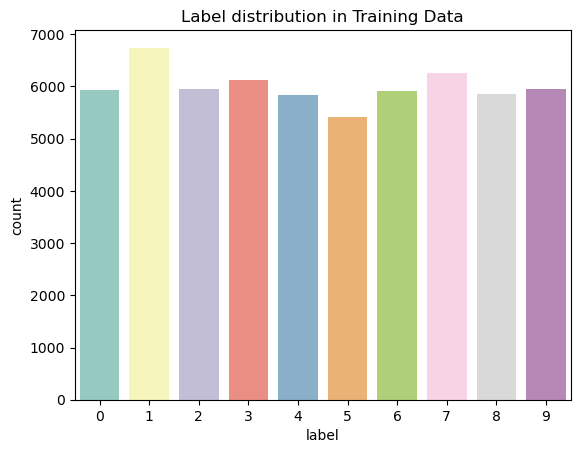

In [6]:
# check label distribution in test and train datasets
sns.countplot(x="label", data=mnist_train, palette="Set3").set(
    title="Label distribution in Training Data")

/tmp/ipykernel_12181/1845494732.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=mnist_test, palette="Set2").set(


[Text(0.5, 1.0, 'Label distribution in Test Data')]

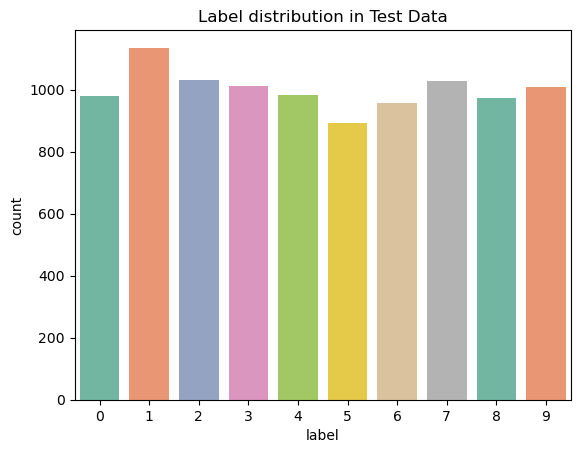

In [7]:
sns.countplot(x="label", data=mnist_test, palette="Set2").set(
    title="Label distribution in Test Data")

/tmp/ipykernel_12181/3593908521.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i].set_title(str(int(pixel_data[-1])), color= 'black', fontsize=20)


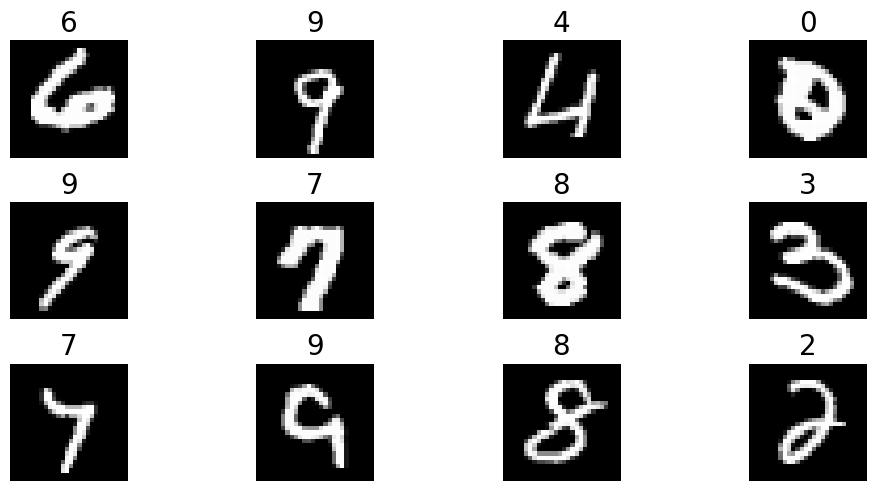

In [8]:
# visualise some of the images from train dataset
# display 4 images per row
fig, axes = plt.subplots(3,4, figsize=(10,5))
# set a tight layout for better spacing between plots
fig.tight_layout()
axes = axes.flatten()
# generate 12 random row numbers to select from mnist_train dataframe
idx = np.random.randint(0,mnist_train.shape[0],size=12)
for i in range(12):
    # get the row data
    pixel_data = mnist_train.iloc[idx[i]]
    # use imshow to build the image using pixel info
    # reshape is necessary because imshow expects a 2d array structure as input
    axes[i].imshow(np.array(pixel_data[:784]).reshape(28,28), cmap='gray')
    axes[i].axis('off') 
    # add the label of the image as title
    axes[i].set_title(str(int(pixel_data[-1])), color= 'black', fontsize=20)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# splitting the training data into train and validate datasets
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train, 
                                                  test_size=0.1)

### Preparing the CNN

In [10]:
# Imports needed to create the CNN
from keras.utils import to_categorical  # convert to one-hot-encoding
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose
from keras import optimizers
from keras import models

In [11]:
# add a channel dimension to the images
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
x_val= np.expand_dims(x_val, axis=-1)

# one hot encoding all the labels
y_train = to_categorical(y_train,10)
y_test = to_categorical(y_test,10)
y_val = to_categorical(y_val,10)

cnn_model = models.Sequential()

cnn_model.add(Conv2D(filters=20, kernel_size=(5, 5), 
                   activation='relu', padding="same", 
                   input_shape=(28,28,1)))
cnn_model.add(BatchNormalization(axis=-1))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(filters=20, kernel_size=(4, 4), 
                   activation='relu', padding="same"))
cnn_model.add(BatchNormalization(axis=-1))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(filters=20, kernel_size=(4, 4), 
                   activation='relu', padding="same"))
cnn_model.add(BatchNormalization(axis=-1))
cnn_model.add(Dropout(0.2))

cnn_model.add(Flatten())
cnn_model.add(Dense(200, activation='relu'))

cnn_model.add(Dense(10, activation='softmax'))

cnn_model_opt = optimizers.Adam(decay=1e-4)

print(cnn_model.summary())

/home/ryanpuglia/.conda/envs/adv_attack_notebook/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1748253366.969433   12181 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1748253367.206673   12181 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:17482

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 20)     │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 20)     │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 20)     │         6,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 20)     │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 20)     │         6,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 20)     │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15680)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │     3,136,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,151,810 (12.02 MB)

 Trainable params: 3,151,690 (12.02 MB)

 Non-trainable params: 120 (480.00 B)

None


In [12]:
# Compiling and training the model
cnn_model.compile(optimizer = cnn_model_opt , loss = "categorical_crossentropy", 
                  metrics=["accuracy"]) 

cnn_model_fit = cnn_model.fit(x_train, 
                        y_train,
                        validation_data = (x_val, y_val),
                        batch_size=128,
                        epochs=10)

cnn_test_accuracy = cnn_model.evaluate(x_test, y_test)
print("Accuracy on test data is : ", cnn_test_accuracy[1] * 100)

Epoch 1/10


I0000 00:00:1748253371.995123   12262 service.cc:146] XLA service 0x7fdb6c0016b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748253371.995140   12262 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-05-26 11:56:12.036522: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-26 11:56:12.185947: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


 61/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7094 - loss: 1.2355

I0000 00:00:1748253375.575250   12262 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8973 - loss: 0.4030 - val_accuracy: 0.9323 - val_loss: 0.2026
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9836 - loss: 0.0518 - val_accuracy: 0.9817 - val_loss: 0.0699
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9894 - loss: 0.0333 - val_accuracy: 0.9852 - val_loss: 0.0640
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9911 - loss: 0.0266 - val_accuracy: 0.9840 - val_loss: 0.0678
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9930 - loss: 0.0227 - val_accuracy: 0.9858 - val_loss: 0.0704
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9937 - loss: 0.0191 - val_accuracy: 0.9867 - val_loss: 0.0579
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9930 - loss: 0.0218 - val_accuracy: 0.9875 - val_loss: 0.0610
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9956 - loss: 0.0139 - val_accuracy: 0.9885 - va

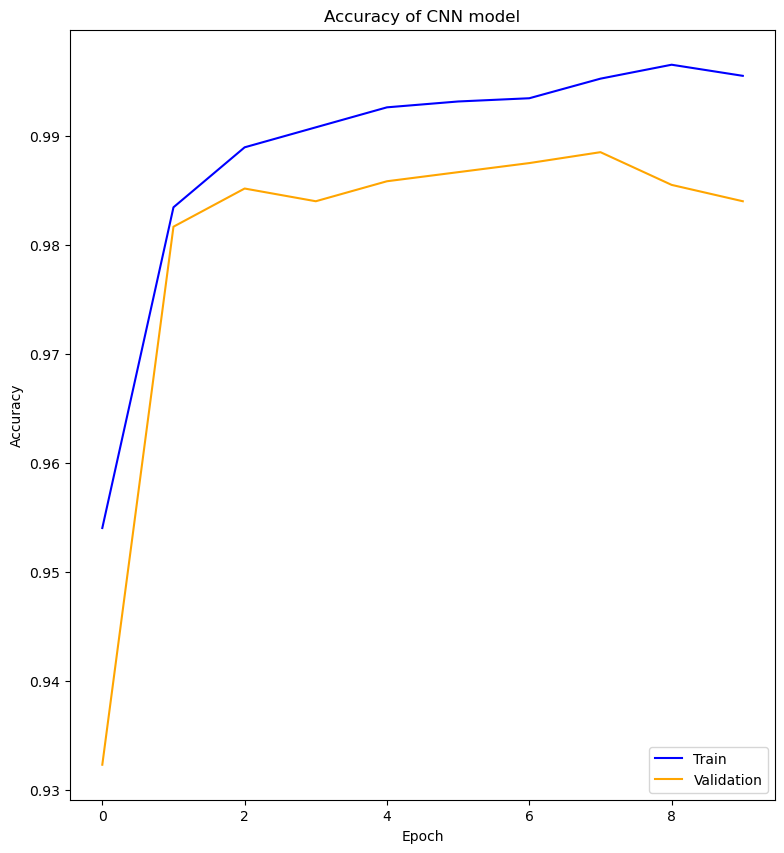

In [19]:
plt.figure(figsize=(20,10))
# plot the accuracy for the train and validation datset
plt.subplot(1,2,1)
plt.plot(cnn_model_fit.history['accuracy'], color='blue', 
         label="Training accuracy")
plt.plot(cnn_model_fit.history['val_accuracy'], color='orange', 
         label="Validation accuracy")
plt.title("Accuracy of CNN model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="lower right")

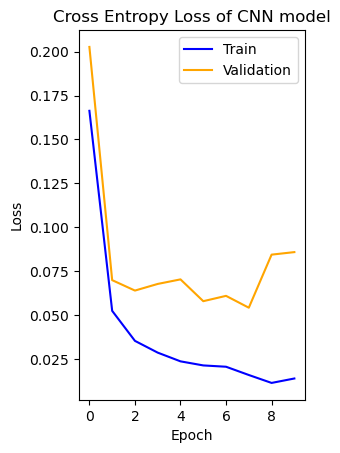

In [14]:
# plot the loss of train and validation dataset
plt.subplot(1,2,2)
plt.plot(cnn_model_fit.history['loss'], color='blue', 
         label="Training loss")
plt.plot(cnn_model_fit.history['val_loss'], color='orange', 
         label="Validation loss")
plt.title("Cross Entropy Loss of CNN model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper right")

In [15]:
# visualising examples that are misclassified
y_test_pred = cnn_model.predict(x_test)
errors = np.absolute(y_test_pred - y_test)
errors = [np.round(np.sum(each)) for each in errors]

# check the unique error values generated
set(errors)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


{0.0, 1.0, 2.0}

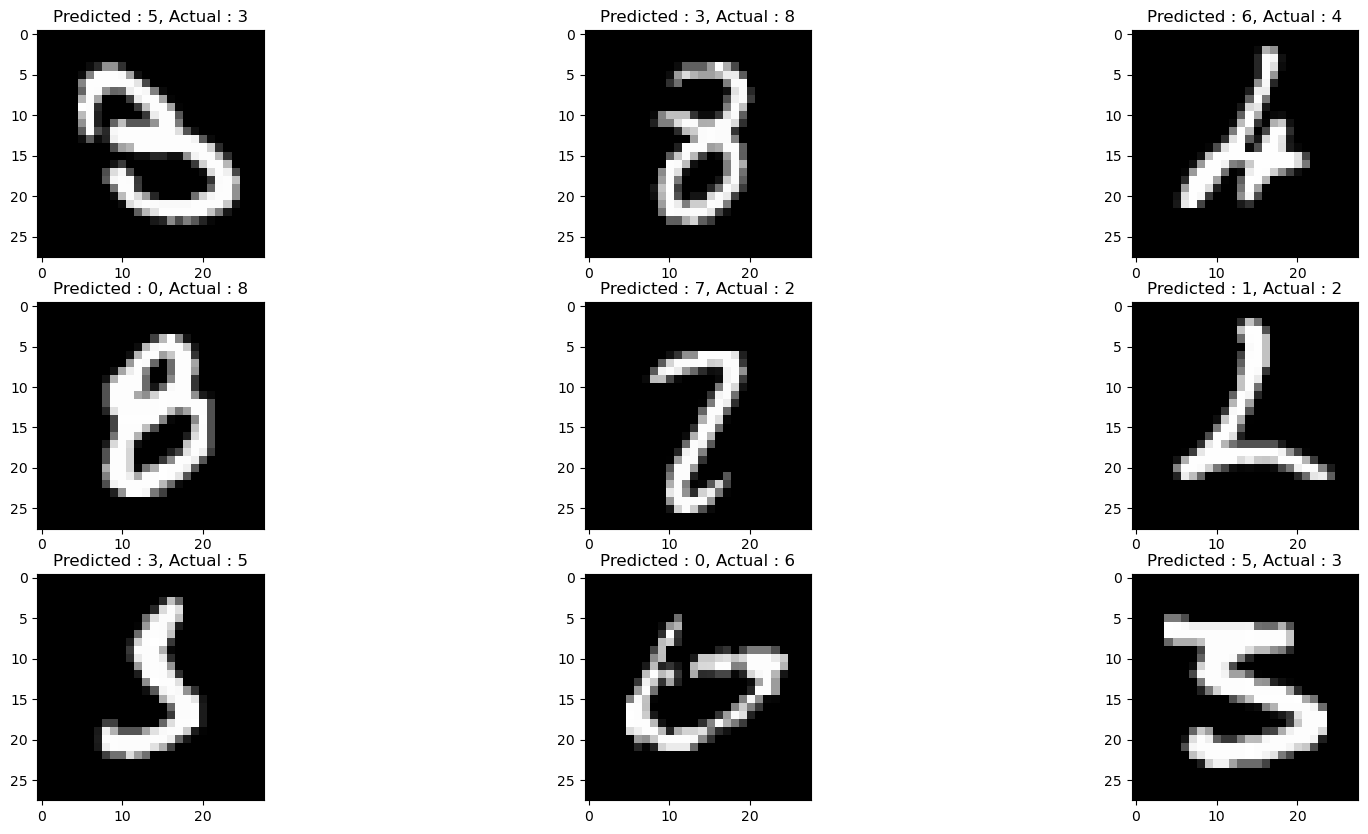

In [17]:
# since 2 is the max error difference i will fetch these indices
# and check if the index with maxvalue match in our prediction and test label
# fetching the max value because of one hot encoding
error_index = [i for i, x in enumerate(errors) if (x==2.0 and 
                                                       (np.argmax(y_test_pred[i])
                                                        !=
                                                        np.argmax(y_test[i])))]

# plot the images
plt.figure(figsize=(20,10))
for i,index in enumerate(error_index[:9]):
    plt.subplot(3,3,i+1)
    plt.title("Predicted : {}, Actual : {}".format(np.argmax(y_test_pred[index]),
                                                   np.argmax(y_test[index])))
    plt.imshow(np.reshape(x_test[index],(28,28)), cmap="gray")

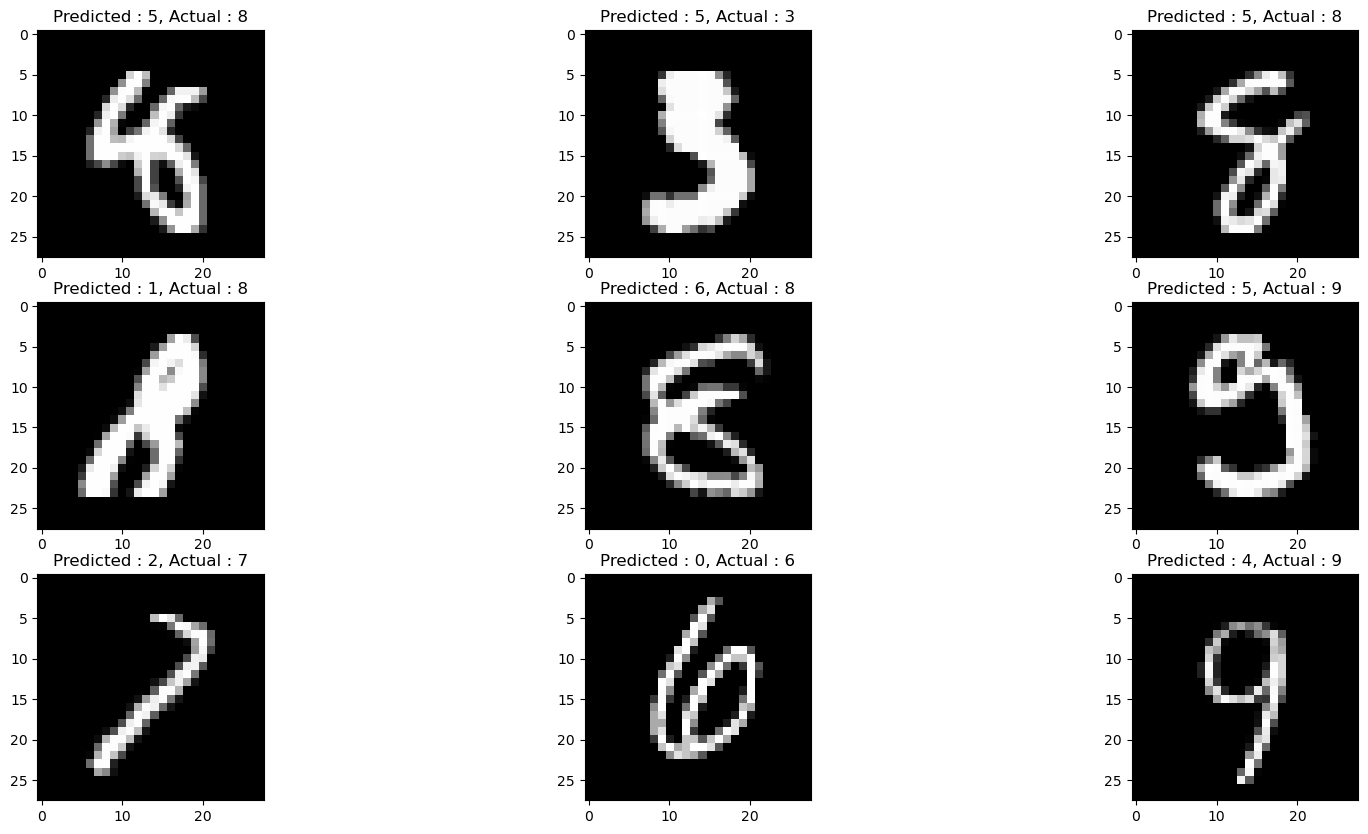

In [18]:
# repeating the same steps as above where error difference is 1.0
error_index = [i for i, x in enumerate(errors) if (x==1.0 and 
                                                       (np.argmax(y_test_pred[i])
                                                        !=
                                                        np.argmax(y_test[i])))]

# plot the images
plt.figure(figsize=(20,10))
for i,index in enumerate(error_index[:9]):
    plt.subplot(3,3,i+1)
    plt.title("Predicted : {}, Actual : {}".format(np.argmax(y_test_pred[index]),
                                                   np.argmax(y_test[index])))
    plt.imshow(np.reshape(x_test[index],(28,28)), cmap="gray")